In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

def household_guess(a_grid,e_grid,r,w,gamma):
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis]
    V_prime = (1+r)*(wel/2)**(-gamma)
    return V_prime

# Important: V_prime MUST be named v_prime_p in the argument of the function! Otherwise, raises error

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init=household_guess)
def household(V_prime_p,a_grid,e_grid,r,w,beta,gamma):
    c_prime = (beta*V_prime_p)**(-1/gamma)
    new_grid = c_prime + a_grid
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis]

    a = interpolate.interpolate_y(new_grid,wel,a_grid)
    misc.setmin(a,a_grid[0])
    c = wel - a
    V_prime= (1+r)*c**(-gamma)

    return V_prime,a,c

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'beta', 'gamma', 'Pi']
Macro outputs: ['A', 'C']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c']


In [2]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid


household_ext = household.add_hetinputs([make_grid])

print(household_ext)
print(f'Inputs: {household_ext.inputs}')

<HetBlock 'household' with hetinput 'make_grid'>
Inputs: ['r', 'w', 'beta', 'gamma', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA']


In [3]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y


@simple
def mkt_clearing(K, A, Y, C, delta):
    asset_mkt = A - K
    goods_mkt = Y - C - delta * K
    return asset_mkt, goods_mkt

ks = create_model([household_ext, firm, mkt_clearing], name="Krusell-Smith")
print(ks.inputs)

['beta', 'gamma', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'K', 'L', 'Z', 'alpha', 'delta']


In [4]:

calibration = {'gamma': 1, 'delta': 0.025, 'alpha': 0.11, 'rho_e': 0.966, 'sd_e': 0.5, 'L': 1.0,
               'nE': 7, 'nA': 500, 'amin': 0, 'amax': 200}
unknowns_ss = {'beta': 0.98, 'Z': 0.85, 'K': 3.}
targets_ss = {'r': 0.01, 'Y': 1., 'asset_mkt': 0.}

ss = ks.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='hybr')

print(ss)

<SteadyStateDict: ['gamma', 'delta', 'alpha', 'rho_e', 'sd_e', 'L', 'nE', 'nA', 'amin', 'amax', 'beta', 'Z', 'K', 'r', 'w', 'Y', 'A', 'C', 'asset_mkt', 'goods_mkt'], internals=['household']>


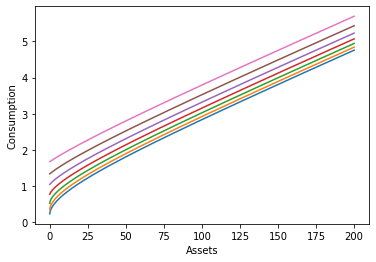

In [5]:
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'].T)
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()

In [13]:
asset_grid = grids.agrid(amin = 0.1,amax = 5,n = 100)
e_grid, _, Pi = grids.markov_rouwenhorst(rho=0.8, sigma=1, N=4)

In [15]:
aaa = (1+0.01)*asset_grid[np.newaxis,:] + 0.5*e_grid[:,np.newaxis]

In [18]:
indxs = np.nonzero(aaa < 1)

In [27]:
from numba import vectorize

def my_sum(a,b):
    return a + b

In [28]:
my_sum([1,2,3],[4,5,6])

[1, 2, 3, 4, 5, 6]

In [120]:
def bissection_onestep(f,a,b):
    if not all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

In [121]:
def f(x,c): return x - c
c = np.array([1,2,4])
aa = np.array([-1.0,-1.0,-1.0])
bb = np.array([2.0,3.0,5.0])

a,b = bissection_onestep(lambda x : f(x,c),aa,bb)

In [122]:
a,b

(array([0.5, 1. , 2. ]), array([2., 3., 5.]))

In [123]:
bissection_onestep(lambda x : f(x,c),a,b)

(array([0.5, 2. , 3.5]), array([1.25, 2.  , 5.  ]))

In [124]:
def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    return a,b,i

In [125]:
vec_bissection(lambda x : f(x,c),aa,bb)

(array([1., 2., 4.]), array([1., 2., 4.]), 39)

In [80]:
np.max(np.abs(np.array([1,2,5,9]) - np.array([3,4,1,243])))

234

In [29]:
def solve_household(c,we,rest,gamma,v,phi):
    return c - we*(we/(-phi*c**gamma))**(1/v) - rest

In [62]:
we = 0.5*e_grid[:,np.newaxis]
rest = (1+0.01)*asset_grid[np.newaxis,:] - asset_grid[0]
solve_household(0.1,we,rest,1,1,1).shape

(4, 100)